<div style="background: linear-gradient(135deg, #034694 0%, #1E8449 50%, #D4AC0D 100%); color: white; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <h1 style="color: #FFF; text-shadow: 1px 1px 3px rgba(0,0,0,0.5);">💬 | Step 3: Be More Cost-Effective With Distillation </h1>
        <p style="font-size: 16px; line-height: 1.6;">
            We have the model customized to provide the right tone and style. But we are using a large (slow and expensive) model for a very narrow and focused task. Let's see how we can distill the knowledge to a smaller (faster and cheaper) model to get comparable accuracy with better efficiency - by trading in general-purpose LLMs for a narrower task-specific intelligence.
        </p>
</div>

---

## 1. Check Environment Setup



In [2]:
# First, make sure required environment variables are set
import os

openai_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4o"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

if not openai_key or not openai_endpoint:
    print("Error: Missing AZURE_OPENAI_KEY or AZURE_OPENAI_ENDPOINT environment variable.")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4o
Using API Version: 2025-02-01-preview


In [3]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

---
## 2. Building Our Grader

Distillation is about having a "teacher" model transfer its learning to a "student" model, thereby allowing it to perform a _narrower_ task with comparable accuracy. To understand if our distillation had the desired effect, we typically _grade_ the student model before and after distillation - and show that the grades on that task improved significantly.

To do this, we need a _grader_ - some model that is capable of "reasoning" on a given response to see if it meets our desired criteria for "tone & style". By using the same grader throughout, we can make sure we get a consistent outcome in terms of evaluations. To create an effective grader we take 3 steps:

1. We curate a set of **baseline** questions and answers that are the gold standard for responses. A "good" grader would rank these very highly when asked.
2. We define a set of **grading** criteria that the grader will use to come up with a score on the responses. These must be clear and consistent guidelines.
3. We run the grader on that gold standard to see how our **assessment** rubric holds up. If the results look good, we have a grader ready to go - else we refine and retry.

By the end of this step, we will have an effective grader ready to use!




### 2.1 Curate Baseline Responses

In our case, we can simply take a subset of the training data from the previous step since we know it is the kind of "good" responses we want to see. We store it in a new file (`distill_sft_baseline.json`) that we can then upload to our Microsoft Foundry project, for use in a later step. Let's review the data in the file and upload it.

In [5]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
baseline_jsonl_df = pd.read_json("data/demo/distill_sft_baseline.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in baseline_jsonl_df.head(5).iterrows()
    ]
)

,question,answer
0,Is water-based polyurethane better than oil-based?,"🤔 Both have benefits! Water-based at $43 dries faster, oil-based at $34 gives amber tone. Which matters most?"
1,Can I get detail brushes for trim work?,🎨 Exactly! Artist Detail Brush Set at $13 provides precise control for trim. Angled options too?
2,What's the cheapest interior paint option?,💰 Good value! Premium Interior Latex Flat at $40 offers excellent coverage. Quantity calculator?
3,What's the best brush for latex paint?,🖌️ Excellent! Synthetic Brush Set at $16 is perfect for latex paints. Different sizes needed?
4,What paint should I use for my kitchen cabinets?,🍳 Excellent choice! Interior Semi-Gloss Paint at $47 is perfect for cabinets. Need primer too?


### 2.2 Upload Baseline Data To Cloud

In [7]:
# Create a cloud-hosted file with baseline data for evaluations (purpose="evals")
# An "evals" file is a special type of file that can be used in evaluation jobs 
# - it has to be in JSONL format but its properties depend on how grader is setup
grader_eval_file = None
with open("data/demo/distill_sft_baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")

Created eval file:
{
  "id": "file-7278895a0407488a85706fe10330b4bb",
  "bytes": 3729,
  "created_at": 1761797154,
  "filename": "distill_sft_baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 2.3 Create a Helpfulness Evaluator

The Grader is just like a custom evaluator that takes an input ("question", "answer") and scores it for the desired metric ("Helpfulness") using a set of custom criteria that we define. This is an example of AI-Assisted evaluation (or LLM as a judge) where we use an LLM to execute a task ("grader this") where we describe the parameters of the task in the prompt template we provide. Let's see that in action.

In [8]:
# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o3"

In [9]:
# Next we create a custom Grader that will score the responses for "Helpfulness" on a scale of 0-10
# using the custom rubric below - where 0 is "not helpful at all" and 10 is "extremely helpful".

# We want it to grader our "student" responses later, based on the same criteria. So let's make sure we get our rubric right.
# We want good answers to score high - and bad answers to be penalized heavily (get 0)

GRADER_PROMPT = """

You are an expert in assessing polite and helpful customer service responses

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria

Judge the answer by using two metrics to compute a final score.

### Metric 1: Is the answer polite?

Give this a score in the range of 1 to 5 where:
- 1 means the answer was rude, disrespectful or dismissive
- 3 means the answer was neutral, neither polite nor rude
- 5 means the answer had an emoiji followed by a greeting or an acknowledgement of the user question

### Metric 2: Is the answer helpful?

Give this a score in the range of 1 to 5 where:
- 1 means the response did not end with an offer to help further
- 3 means the response ended with a generic offer to help
- 5 means the response ended with an offer to help that was clearly related to the user's question

### Metric 3: Is the answer informative?
Give this a score of 0 or 1 where:
- 0 means the answer did not mention any specific product or product-related fact
- 1 means the answer mentioned a specific product or solution

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1 + Metric 2) * (Metric 3)`

This means that if Metric 3 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 2>", 
      "result": <string representation of Metric 2's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions will be about paint products and related topics. Deep research is not required. Use common sense to determine if the answer is polite, helpful and factual.

```
"""

### 2.4 Put the Grader Together

In [10]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

### 2.5 Submit The Evaluation Task

In [11]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")

⚖️ Submitted grader evaluation eval_6902e44bf4088191bfa465a19ec6d390.


### 2.6 Run The Evaluation Job

In [12]:
# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.

RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": { "type": "file_id", "id": grader_eval_file.id }
}
grader_run = client.evals.runs.create(
    name=f"zava-tone-grader-{GRADER_MODEL}",
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")

🏃‍➡️ Submitted run evalrun_6902e463fc588191a9b4709ecdcedc96 for eval_6902e44bf4088191bfa465a19ec6d390.


### 2.7 Poll For Evaluation Results

In [13]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

⏱️ Elapsed time: 0 minutes 10 seconds
🏁 Run evalrun_6902e463fc588191a9b4709ecdcedc96: completed!


### 2.8 View & Analyze Results

You can see these on the Microsoft Foundry portal - or run a script to visualize them here

Get Evaluation Runs: eval_6902e44bf4088191bfa465a19ec6d390

Combined Evaluation Summary
                                  Run ID            Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_6902e463fc588191a9b4709ecdcedc96 zava-tone-grader-o3  None completed               100.0                  0.0 eval_6902e44bf4088191bfa465a19ec6d390 zava-tone-baseline-ef9ba7d2


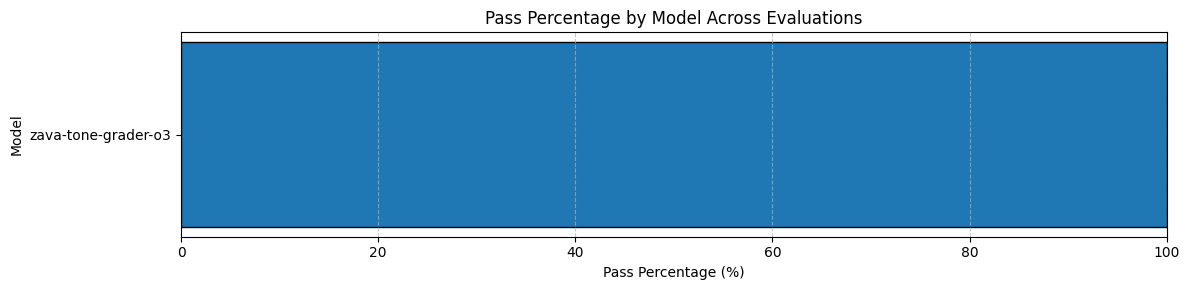

Fetching scores...

Score Summary Table:
Model             Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None zava-tone-baseline-ef9ba7d2          7.90      4.00     10.00            6.00            6.00            8.00           10.00           10.00


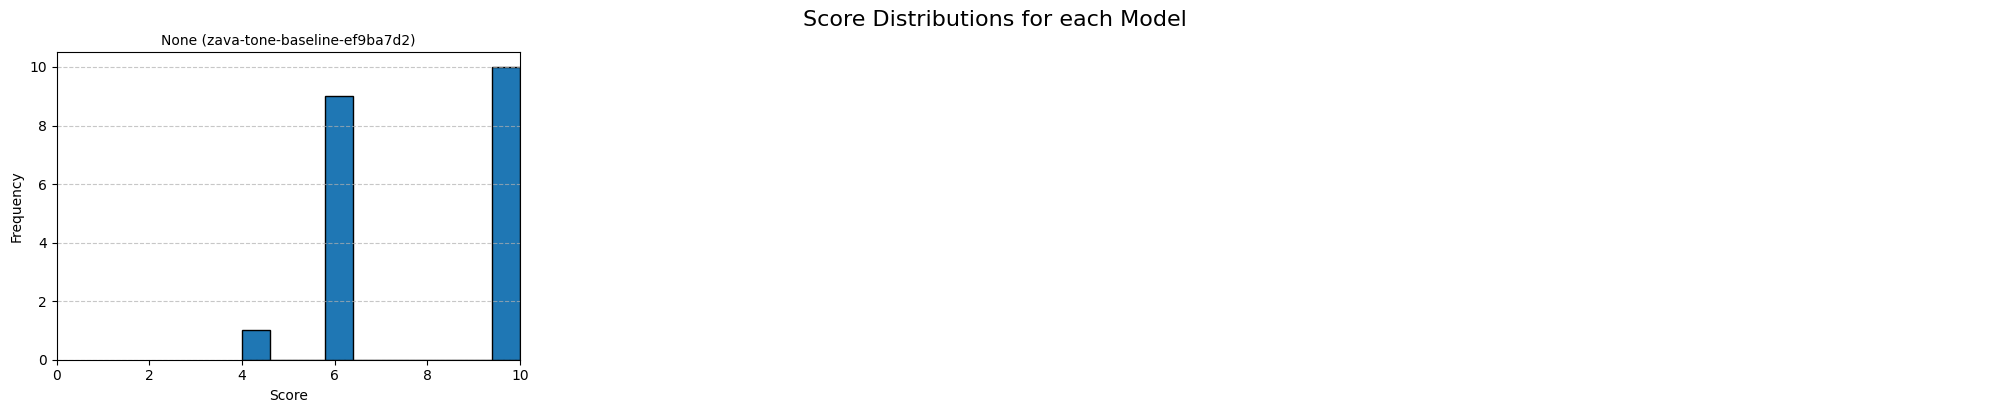

In [14]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty on-brand for Zava tone. 
# This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

---

## 3. Baseline Testing Our Candidate Models

### 3.1 Curate Q&A Dataset

In [15]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
qa_jsonl_df = pd.read_json("data/demo/distill_sft_qa.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in qa_jsonl_df.head(5).iterrows()
    ]
)


,question,answer
0,What's the best paint for kitchen walls?,Interior Semi-Gloss Paint is ideal for kitchens due to its moisture resistance and washable finish.
1,How much does Premium Interior Latex Flat cost?,$40.
2,What type of paint should I use for bathroom walls?,"Interior Semi-Gloss Paint, as it's moisture resistant and washable."
3,Is there an environmentally friendly paint option available?,"Yes, Zero VOC Interior Paint for healthy indoor air quality."
4,What's the price of Zero VOC Interior Paint?,$52.


### 3.2 Split Training & Validation

In [6]:
import json

qa = []
with open("data/demo/distill_sft_qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")


Number of Q/A pairs: 306


In [7]:

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 50/50.
split_at = int(len(qa) / 2)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

153 pairs for baseline testing, 153 for validation.


### 3.3 Upload baseline (training) set

In [18]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./zava-tone-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

Created baseline file:
{
  "id": "file-8628f84683de4bddac49ac3ba631b650",
  "bytes": 26525,
  "created_at": 1761797342,
  "filename": "zava-tone-baseline-ef9ba7d2.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 3.4 Create The Baseline Evaluation

In [19]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "You are Cora, a polite, factual and helpful assistant for Zava, a DIY hardware store."

# We'll use a flee of base models as our baseline, including `o3` (our grader).
BASE_MODELS = [
    "o3",
    "o4-mini",
    "o3-mini",
    "gpt-4.1-mini",
    "gpt-4.1-nano",
    "gpt-4o",
    "gpt-4o-mini"
]

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")

⚖️ Created baseline eval eval_6902e50192988191b41a23ce71bd5647


### 3.5 Run Baseline Evaluation

In [20]:
# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": baseline_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 20_000 } if model.startswith("o") else { "max_completions_tokens": 100 }, # XXX
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)

🏃‍➡️ Created run evalrun_6902e50ecfe08191bcb2689ba5982b56 for eval eval_6902e50192988191b41a23ce71bd5647
🏃‍➡️ Created run evalrun_6902e50fb9948191a8de2efdb2bd0f1b for eval eval_6902e50192988191b41a23ce71bd5647
🏃‍➡️ Created run evalrun_6902e51045b881919132d6b2c11146f8 for eval eval_6902e50192988191b41a23ce71bd5647
🏃‍➡️ Created run evalrun_6902e510c828819197f4fdd4a4e8daef for eval eval_6902e50192988191b41a23ce71bd5647
🏃‍➡️ Created run evalrun_6902e5119a7481918d692ca2de0d2500 for eval eval_6902e50192988191b41a23ce71bd5647
🏃‍➡️ Created run evalrun_6902e5120fd08191b814628f4cd538b8 for eval eval_6902e50192988191b41a23ce71bd5647
🏃‍➡️ Created run evalrun_6902e513380881919df06ceea133b535 for eval eval_6902e50192988191b41a23ce71bd5647


### 3.6 Poll For Evaluation Results

In [21]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

🏃‍➡️ Run o3-ef9ba7d2: completed
🏃‍➡️ Run o4-mini-ef9ba7d2: completed
🏃‍➡️ Run o3-mini-ef9ba7d2: completed
🏃‍➡️ Run gpt-4.1-mini-ef9ba7d2: completed
🏃‍➡️ Run gpt-4.1-nano-ef9ba7d2: failed
🏃‍➡️ Run gpt-4o-ef9ba7d2: completed
🏃‍➡️ Run gpt-4o-mini-ef9ba7d2: completed
⏱️ Elapsed time: 18 minutes 40 seconds
🏁 All 7 runs completed!


### 3.7 Visualize Results & Pick Model

Get Evaluation Runs: eval_6902e50192988191b41a23ce71bd5647

Combined Evaluation Summary
                                  Run ID              Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_6902e50ecfe08191bcb2689ba5982b56           o3-ef9ba7d2           o3 completed          100.000000            90.196078 eval_6902e50192988191b41a23ce71bd5647 zava-tone-baseline-ef9ba7d2
evalrun_6902e50fb9948191a8de2efdb2bd0f1b      o4-mini-ef9ba7d2      o4-mini completed           97.590361             0.653595 eval_6902e50192988191b41a23ce71bd5647 zava-tone-baseline-ef9ba7d2
evalrun_6902e51045b881919132d6b2c11146f8      o3-mini-ef9ba7d2      o3-mini completed           92.771084             0.000000 eval_6902e50192988191b41a23ce71bd5647 zava-tone-baseline-ef9ba7d2
evalrun_6902e5120fd08191b814628f4cd538b8       gpt-4o-ef9ba7d2       gpt-4o completed           89.189189             0.000000 eval_6902e501

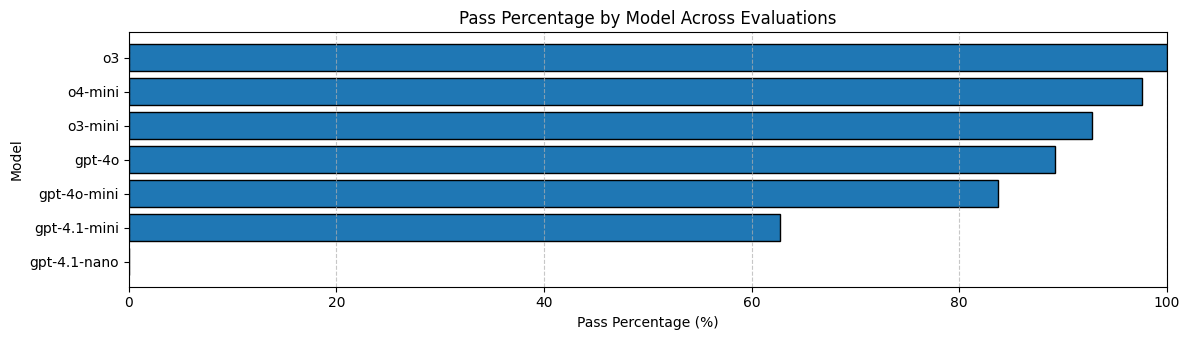

Fetching scores...

Score Summary Table:
       Model             Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
          o3 zava-tone-baseline-ef9ba7d2          7.45      4.00      9.00            4.00            6.00            9.00            9.00            9.00
     o3-mini zava-tone-baseline-ef9ba7d2          6.84      1.00      9.00            4.00            5.00            8.00            9.00            9.00
     o4-mini zava-tone-baseline-ef9ba7d2          4.61      1.00      9.00            4.00            4.00            4.00            5.00            7.40
      gpt-4o zava-tone-baseline-ef9ba7d2          3.86      1.00      9.00            1.90            4.00            4.00            4.00            4.00
 gpt-4o-mini zava-tone-baseline-ef9ba7d2          3.60      1.00      9.00            1.00            4.00            4.00            4.00            4.00
gpt-4.1-mini zava-tone-baseli

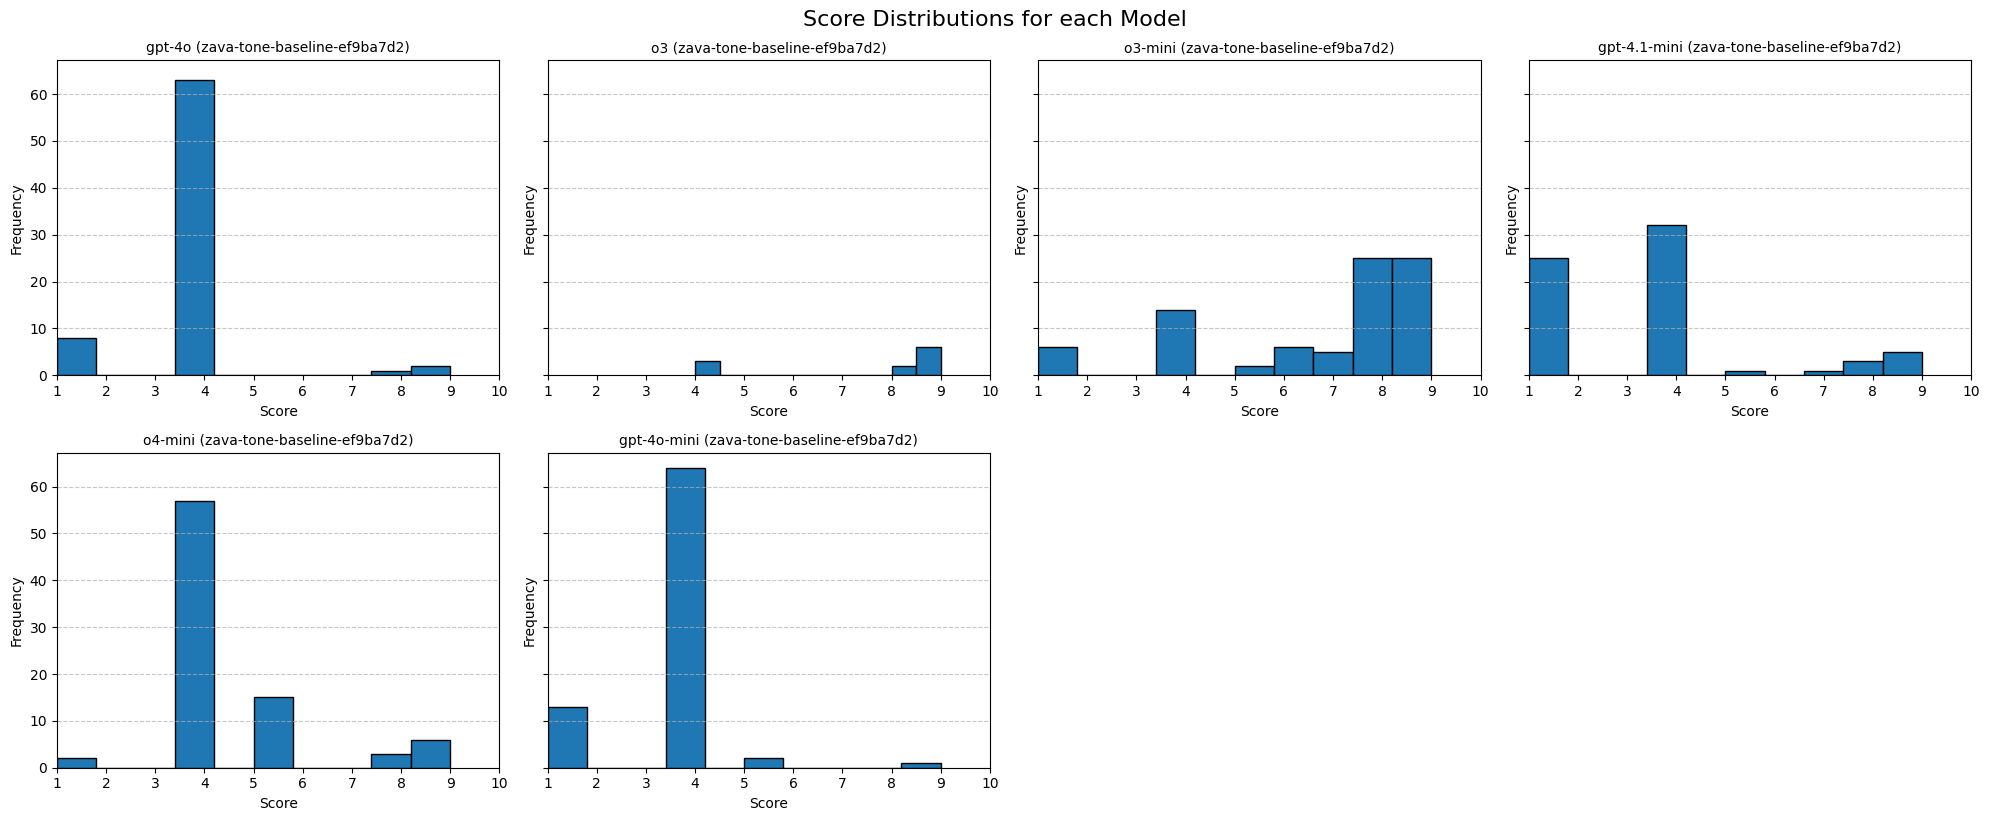

In [22]:
# Let's visualize our evaluation and identify the best and worst performers.
display_evaluation_summary(client, [baseline_eval.id], x_range=(1, 10))

---

## 4. Distillation From Teacher

### 4.1 Find Our Winning Model

In [23]:
# We'll find the model that generated the most "excellent" (>= 6.0) examples of Zava tone.
# NN-TOFIX: Pick the cutoff that gives you at least 10 training samples, else ft job will fail
CUTOFF = 4.0
HIGH_SCORES = {
    "o3": [],
    "o4-mini": [],
    "o3-mini": [],
    "gpt-4.1-mini": [],
    "gpt-4.1-nano": [],
    "gpt-4o": [],
    "gpt-4o-mini": [],
}

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            if result["score"] >= CUTOFF:
                generated = result["sample"]["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:] # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# Time to find the winner! Obviously, this is probably o3...
winning_model = ""
winning_cnt = 0
for key in HIGH_SCORES.keys():
    if len(HIGH_SCORES[key]) > winning_cnt:
        winning_model = key
        winning_cnt = len(HIGH_SCORES[key])
        
print(f"😜 Ok! Let's use {winning_model}. It had {winning_cnt} excellent responses.")

😜 Ok! Let's use o4-mini. It had 81 excellent responses.


### 4.2 Create Our Training Datasets

In [24]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"zava-tone-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"zava-tone-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[winning_model]) * 0.80)
training_data = HIGH_SCORES[winning_model][:split_at]
validation_data = HIGH_SCORES[winning_model][split_at:]
print(f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 64 training / 17 validation rows.
🏋️‍♂️ Created training file:
{
  "id": "file-f03e01912af243f1b297c0f07ae9ebc8",
  "bytes": 178822,
  "created_at": 1761798651,
  "filename": "zava-tone-training-ef9ba7d2.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-57ef136cb2d2468fb52ad97e8cfabca6",
  "bytes": 53609,
  "created_at": 1761798657,
  "filename": "zava-tone-validation-ef9ba7d2.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


### 4.3 Training The Student

In [ ]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
## NN-TOFIX: Check STUDENT MODEL name - for now we hard-code it after viewing results prio
TEACHER_MODEL = winning_model
STUDENT_MODEL = "gpt-4.1-mini-2025-04-14" #"gpt-4.1-nano-2025-04-14"
SUFFIX = f"{TEACHER_MODEL}-zava-tone-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "globalstandard" }
)
print(f"👨‍🔬 Created fine-tuning job:\n{job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-df87eddb1e054d1a85203a3742c1dc5b",
  "created_at": 1761798786,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 2.0,
    "n_epochs": -1
  },
  "model": "gpt-4.1-mini-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 960367251,
  "status": "pending",
  "training_file": "file-f03e01912af243f1b297c0f07ae9ebc8",
  "validation_file": "file-57ef136cb2d2468fb52ad97e8cfabca6",
  "estimated_finish": 1761802326,
  "suffix": "o4-mini-zava-tone-ef9ba7d2",
  "trainingType": "globalStandard"
}


### 4.4 Wait For Fine Tuning Job

In [26]:
# Wait for our FT job to complete. You may want to go work on some other tasks for now 😜
from IPython.display import clear_output
import time

start_time = time.time()

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(10)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status
    clear_output(wait=True)
    print(f"👨‍🔬 Job {job.id}: {status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 Job ftjob-df87eddb1e054d1a85203a3742c1dc5b: succeeded
⏱️ Elapsed time: 61 minutes 31 seconds
🏁 Fine-tuning finished!


---

## 5. Judging The Distilled Student

### 5.1 Deploy Fine-Tuned Model

In [27]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"zava-tone-distilled-{SUFFIX}"
DEPLOYMENT = {
    "properties": {
        "model": { 
            "format": "OpenAI", 
            "name": job.fine_tuned_model, 
            "version": "1" 
        },
    },
    "sku": { 
        "capacity": 250, 
        "name": "DeveloperTier" 
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly. Since
# we're deploying a 4.1-nano model, this should only take 3-5 minutes tops.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AI_FOUNDRY_NAME"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"🛳️ Submitted deployment {deployment}")

🛳️ Submitted deployment <azure.core.polling._poller.LROPoller object at 0x740ec01a1520>


### 5.2 Wait Till Deployment Ready

In [28]:
# Wait for our deployment to finish provisioning.
from IPython.display import clear_output
import time

start_time = time.time()
status = deployment.status()

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"🛳️ Provisioning {DEPLOYMENT_NAME}: {status}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"🏁 Provisioning finished!")


🛳️ Provisioning zava-tone-distilled-o4-mini-zava-tone-ef9ba7d2: Succeeded
⏱️Elapsed time: 3 minutes 20 seconds
🏁 Provisioning finished!


### 5.3 Upload Validation Data

In [ ]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./zava-tone-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)

### 5.4 Evaluate Student vs. Peers

In [31]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,# distilled
    "gpt-4.1-mini", # student
    "gpt-4o",      # control
]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}
posttraining_eval = client.evals.create(
    name=f"zava-tone-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": posttraining_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 100 }, # XXX again, note the purposeful typo
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)


Created eval eval_6902fa64082c8191b457859e5cab87b1
🏃‍➡️ Created run evalrun_6902fa647e3881919397570d9f59cef6 for eval_6902fa64082c8191b457859e5cab87b1
🏃‍➡️ Created run evalrun_6902fa64ff40819186bf80c8c6f38d60 for eval_6902fa64082c8191b457859e5cab87b1
🏃‍➡️ Created run evalrun_6902fa65ee5081919466a0d5018e4974 for eval_6902fa64082c8191b457859e5cab87b1


### 5.5 Wait For Evaluations

In [32]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run zava-tone-distilled-o4-mini-zava-tone-ef9ba7d2-ef9ba7d2: completed
🏃‍➡️ Run gpt-4.1-mini-ef9ba7d2: completed
🏃‍➡️ Run gpt-4o-ef9ba7d2: completed
⏱️ Elapsed time: 15 minutes 33 seconds
🏁 All 3 runs completed!


---

## 6. Interpret The Results

Get Evaluation Runs: eval_6902fa64082c8191b457859e5cab87b1

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_6902fa647e3881919397570d9f59cef6 zava-tone-distilled-o4-mini-zava-tone-ef9ba7d2-ef9ba7d2 zava-tone-disti completed           89.010989             0.000000 eval_6902fa64082c8191b457859e5cab87b1 zava-tone-posttrain-evaluation-ef9ba7d2
evalrun_6902fa65ee5081919466a0d5018e4974                                         gpt-4o-ef9ba7d2          gpt-4o completed           85.148515             0.000000 eval_6902fa64082c8191b457859e5cab87b1 zava-tone-posttrain-evaluation-ef9ba7d2
evalrun_6902fa64ff40819186bf80c8c6f38d60                                   gpt-4.1-mini-ef9ba7d2    gpt-4.1-mini completed           75.961538             3.267974 eval_6902fa64082c8191b

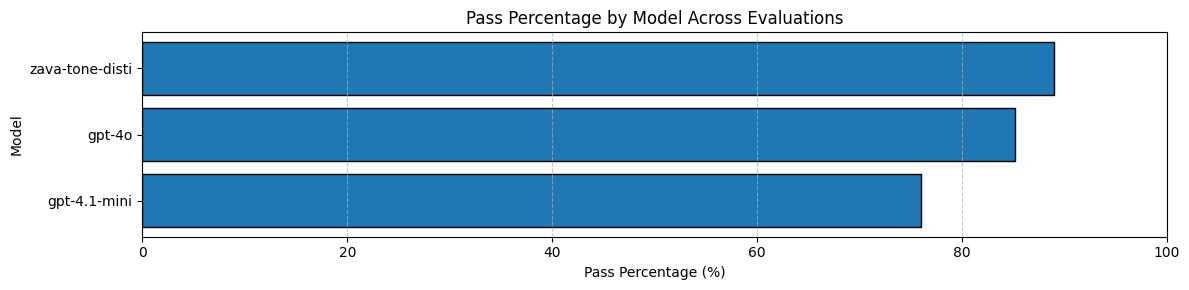

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
         gpt-4o zava-tone-posttrain-evaluation-ef9ba7d2          3.76      1.00      9.00            1.00            4.00            4.00            4.00            4.00
zava-tone-disti zava-tone-posttrain-evaluation-ef9ba7d2          3.68      1.00      5.00            1.00            4.00            4.00            4.00            4.00
   gpt-4.1-mini zava-tone-posttrain-evaluation-ef9ba7d2          3.54      1.00      9.00            1.00            4.00            4.00            4.00            4.00


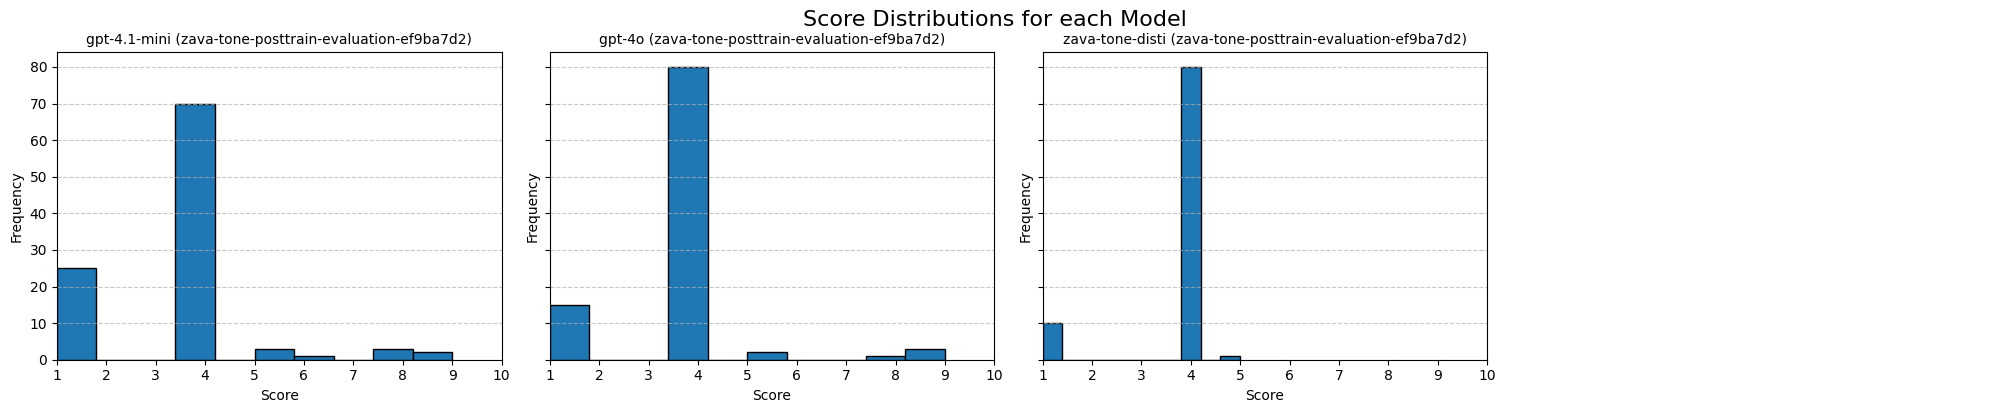

In [ ]:
# Let's visualize our post-training evaluation. Fingers crossed!
from eval_utils import display_evaluation_summary
display_evaluation_summary(client, [posttraining_eval.id], x_range=(1, 10))


Get Evaluation Runs: eval_6902e50192988191b41a23ce71bd5647
Get Evaluation Runs: eval_6902fa64082c8191b457859e5cab87b1

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_6902e50ecfe08191bcb2689ba5982b56                                             o3-ef9ba7d2              o3 completed          100.000000            90.196078 eval_6902e50192988191b41a23ce71bd5647             zava-tone-baseline-ef9ba7d2
evalrun_6902e50fb9948191a8de2efdb2bd0f1b                                        o4-mini-ef9ba7d2         o4-mini completed           97.590361             0.653595 eval_6902e50192988191b41a23ce71bd5647             zava-tone-baseline-ef9ba7d2
evalrun_6902e51045b881919132d6b2c11146f8                                        o3-mini-ef9ba7d2         o3-mini completed     

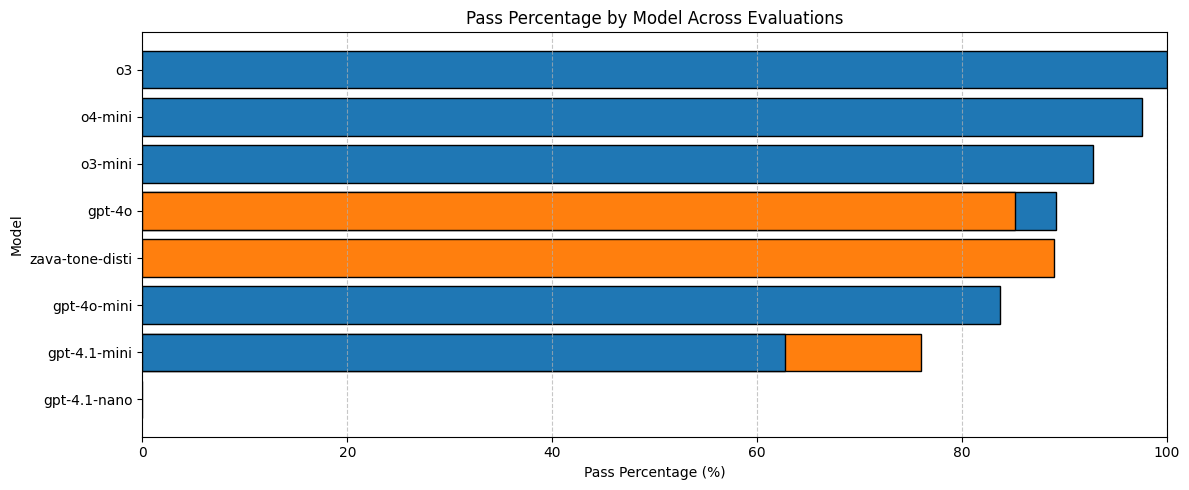

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
             o3             zava-tone-baseline-ef9ba7d2          7.45      4.00      9.00            4.00            6.00            9.00            9.00            9.00
        o3-mini             zava-tone-baseline-ef9ba7d2          6.84      1.00      9.00            4.00            5.00            8.00            9.00            9.00
        o4-mini             zava-tone-baseline-ef9ba7d2          4.61      1.00      9.00            4.00            4.00            4.00            5.00            7.40
         gpt-4o             zava-tone-baseline-ef9ba7d2          3.86      1.00      9.00            1.90            4.00            4.00            4.00            4.00
    gpt-4o-mini             zava-tone-baseline-ef9ba7d2          3.60      1.00      9.00            1.00    

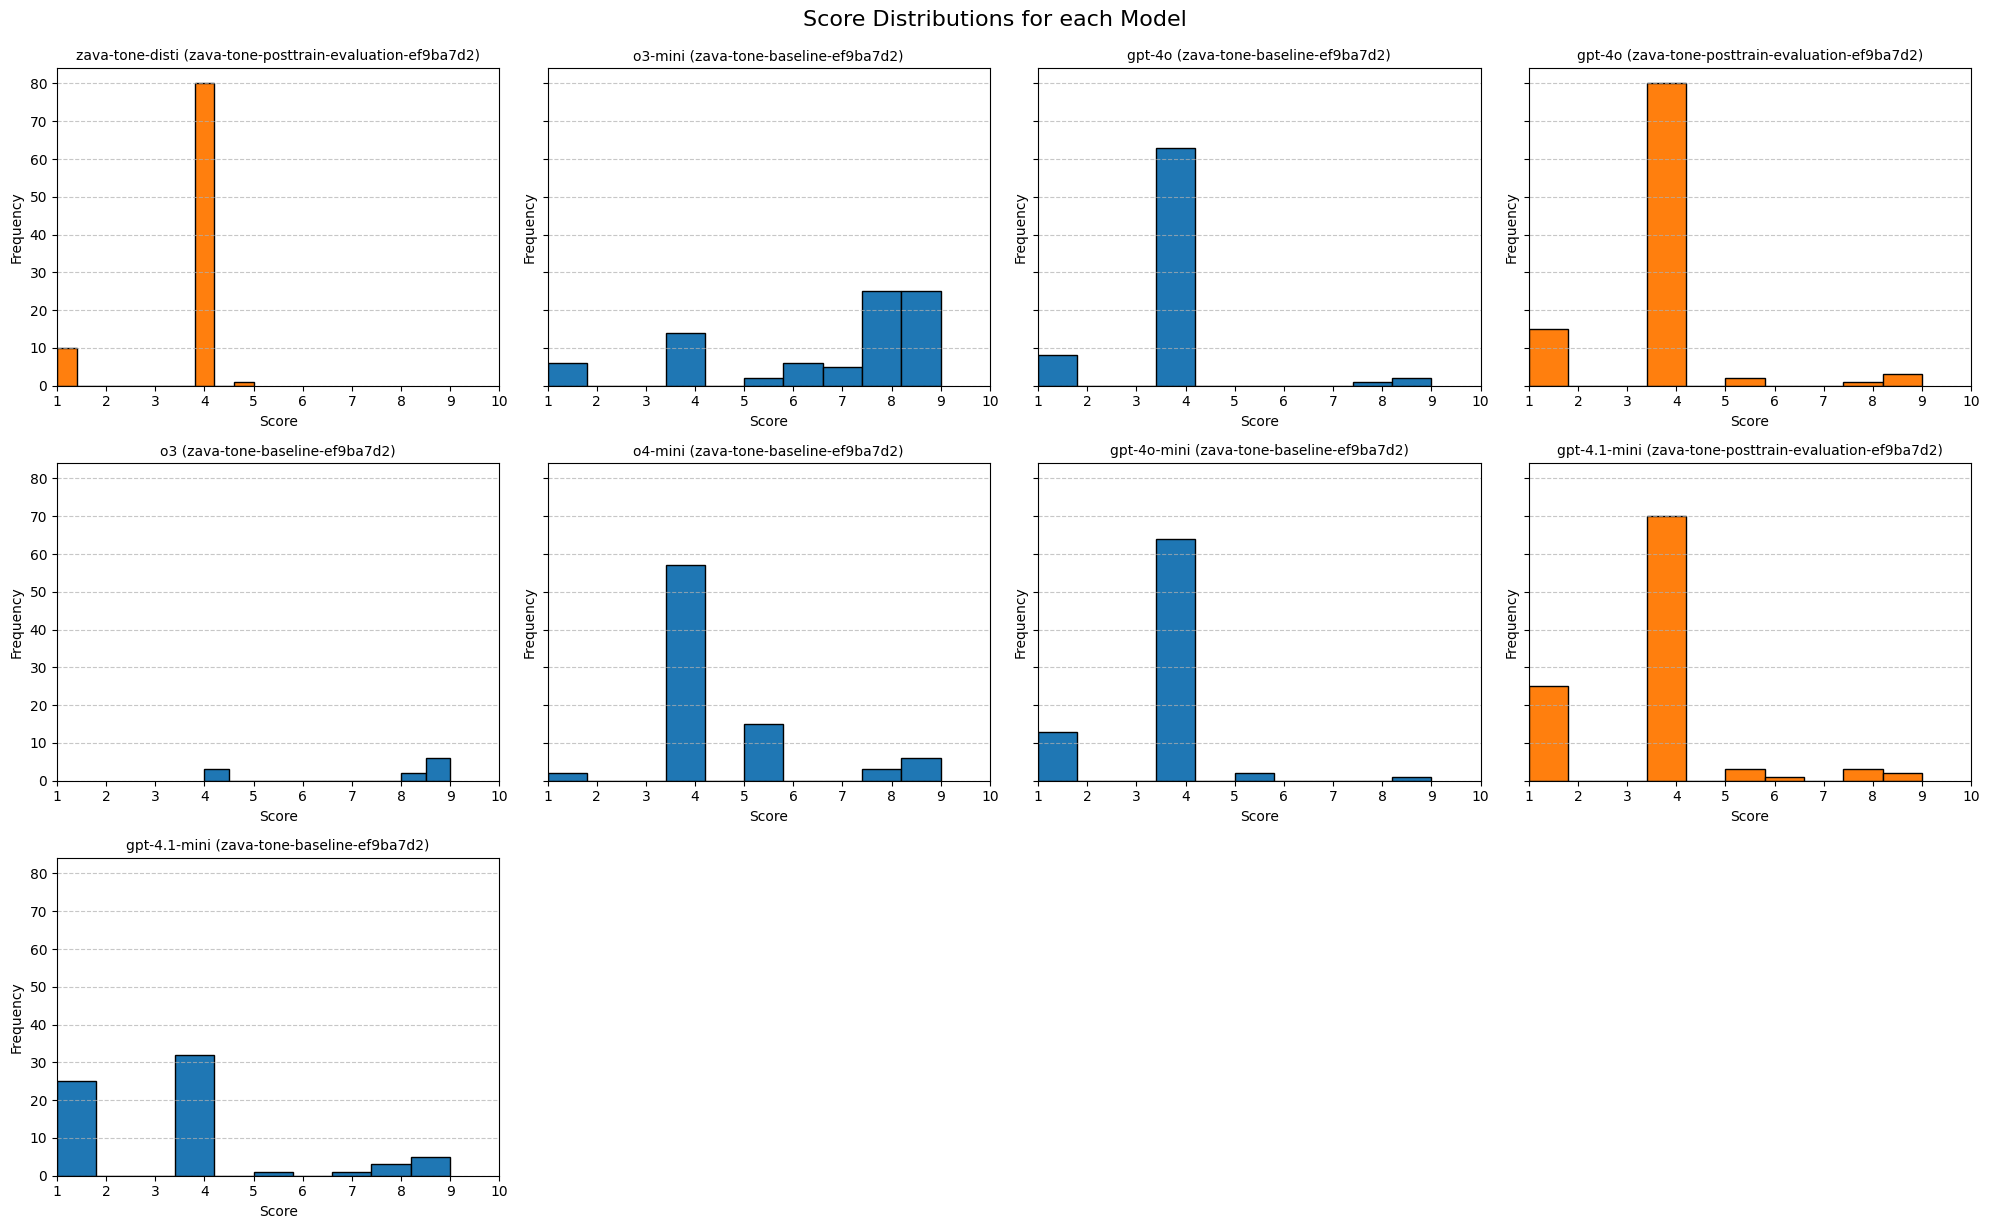

In [ ]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [baseline_eval.id, posttraining_eval.id], x_range=(1, 10))

---

## 7. Teardown

Don't forget to clean up - delete the resource group, purge resources!

---

## 8. Summary 

In this notebook we demonstrated **distillation** using Azure OpenAI *Evaluations*
and *Fine Tuning* features.

We used an objective of *adjusting the tone* of a model to meet our needs, in this
case making its responses sarcastic, while preserving accuracy in results, and
*distilled* the native capabilities of a state-of-the-art reasoning model (`o3`)
into a much smaller, non-reasoning model (`4.1-nano`) to let our agent or app
use the smallest model possible while:

- 🤑 minimizing per-token costs
- 🏎️ improve performance (latency)

We did all this:

- without creating training data directly
- without knowing the ideal student model
- only by knowing how to define our Grader

So to wrap it all up:

1. We described the ideal state to our complex reasoning model in the form of
   a few samples we feel are ideal.
2. We described to the reasoning model (grader) how to judge those examples
   to measure their quality.
3. We let Evaluations and Fine Tuning do the rest!

<div style="display: flex; align-items: center; justify-content: left; padding: 5px; height: 40px; background: linear-gradient(90deg, #7873f5 0%, #ff6ec4 100%); border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.12); font-size: 1.5em; font-weight: bold; color: #fff;">
    Next: Be More Precise with RAFT
</div>